In [1]:
import os
import json
from PIL import Image
import random
import gzip
import shutil
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import cv2

import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
# from huggingface_hub import snapshot_download
# snapshot_download(repo_id="biglab/webui-val", repo_type="dataset", local_dir="/datadrive/webui-val", local_dir_use_symlinks=False)

In [3]:
VISUALIZE = True

In [4]:
DATA_FOLDER = "/datadrive/webui-val/val_split_webui"
SAVE_FOLDER = "./data/"

ids = os.listdir(DATA_FOLDER)

# unzip recursively all .gz files in each id folder
for id in tqdm(sorted(ids)):
    id_path = os.path.join(DATA_FOLDER, id)
    if not os.path.isdir(id_path):
        continue
    gz_files = [f for f in os.listdir(id_path) if f.endswith(".gz")]
    for gz_file in gz_files:
        gz_file_path = os.path.join(id_path, gz_file)

        if not os.path.isfile(gz_file_path[:-3]):
            with gzip.open(gz_file_path, 'rb') as f_in:
                with open(gz_file_path[:-3], 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)

        if os.path.exists(gz_file_path):            
            os.remove(gz_file_path)

100%|██████████| 5666/5666 [00:00<00:00, 46867.89it/s]


In [5]:
ids.sort()
id = ids[0] # random.choice(ids)

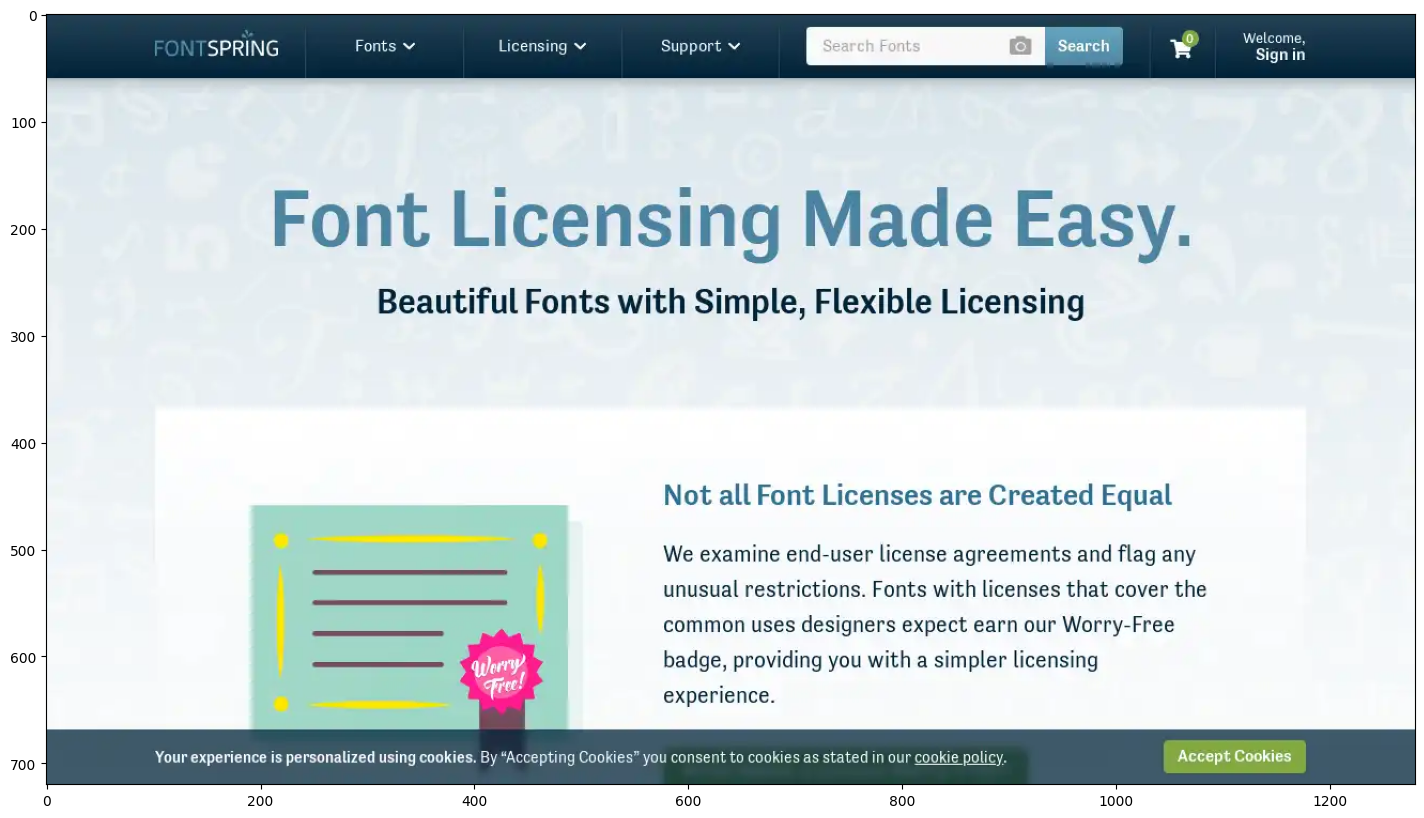

In [6]:
image_path = os.path.join(DATA_FOLDER, "{}/default_1280-720-screenshot.webp".format(id))
if VISUALIZE:
    image = Image.open(image_path)
    plt.figure(figsize=(20, 10))
    plt.imshow(image)

In [7]:
def read_data(id):
    name = "/datadrive/webui-val/val_split_webui/{}/default_1280-720-{}.json"
    axtree = json.load(open(name.format(id, "axtree"), "r"))
    bb = json.load(open(name.format(id, "bb"), "r"))
    box = json.load(open(name.format(id, "box"), "r"))
    style = json.load(open(name.format(id, "style"), "r"))
    viewport = json.load(open(name.format(id, "viewport"), "r"))
    
    return axtree, bb, box, style, viewport


axtree, bb, box, style, viewport = read_data(id)

In [8]:
def get_kept_backend_dom_node_ids(viewport):
    return [k for k, v in viewport.items() if v]

kept_backend_dom_node_ids = get_kept_backend_dom_node_ids(viewport)
len(kept_backend_dom_node_ids)

62

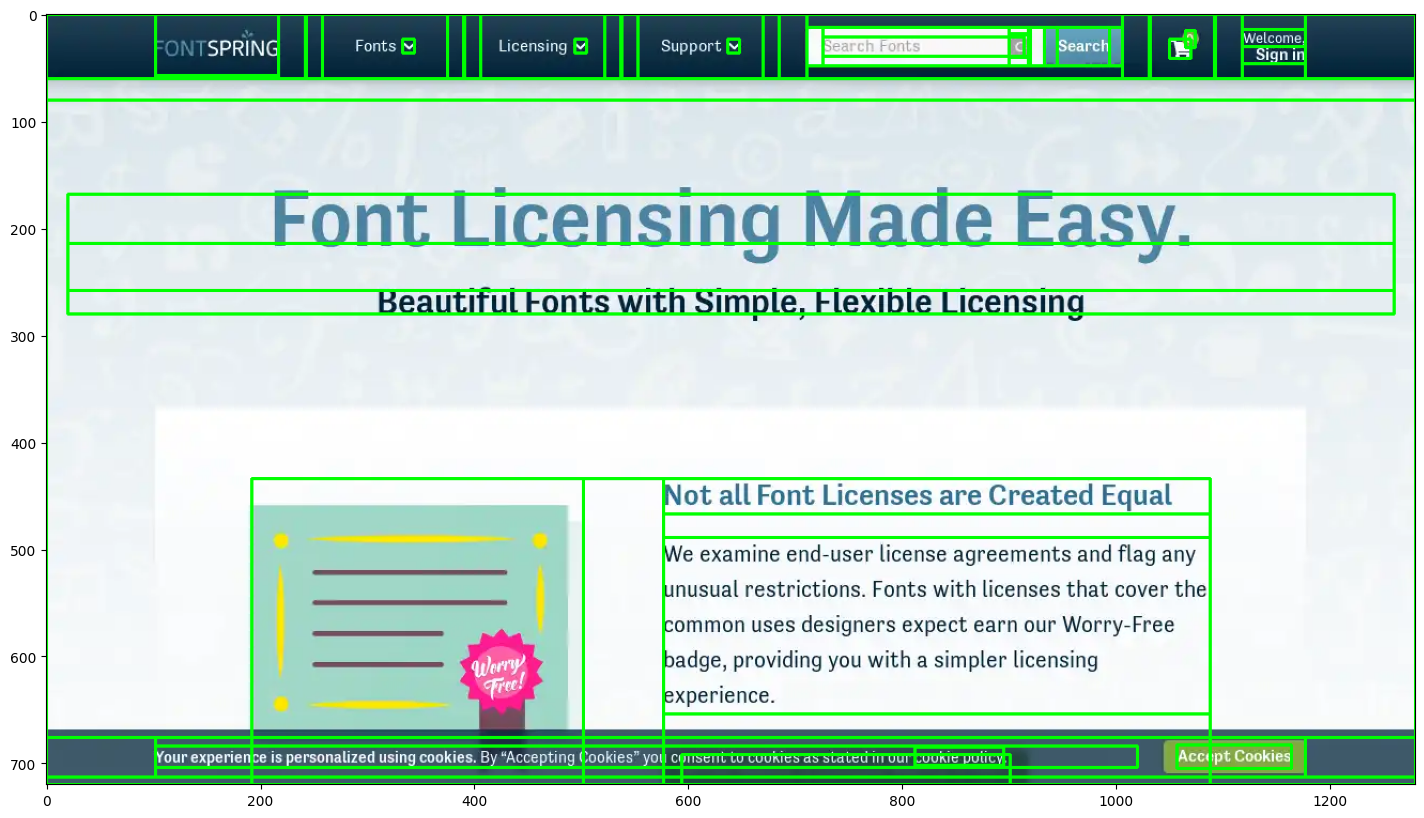

In [9]:
if VISUALIZE:
    np_image = np.array(Image.open(image_path))

    boxes = []
    for dom_id in kept_backend_dom_node_ids:
        try:
            xs = [int(d["x"]) for d in box[dom_id]["content"]]
            ys = [int(d["y"]) for d in box[dom_id]["content"]]

            x1, x2 = min(xs), max(xs)
            y1, y2 = min(ys), max(ys)
    
            # visualize bbox on image
            cv2.rectangle(np_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            boxes.append([x1, y1, x2, y2])
        except:
            continue

    plt.figure(figsize=(20, 10))
    plt.imshow(np_image)

In [10]:
# now we need to build a graph that contains only kept_backend_dom_node_ids
# first we need to build the whole graph of node_ids, then we truncate it to make smaller graph which contains only kept_backend_dom_node_ids
def build_element_graph(axtree, kept_backend_dom_node_ids):
    # make sure that all backend dom node ids are in the axtree
    assert len(set([str(node.get("backendDOMNodeId")) for node in axtree["nodes"] if node.get("backendDOMNodeId") is not None]).intersection(set(kept_backend_dom_node_ids))) == len(kept_backend_dom_node_ids)

    # build the whole graph with all nodes
    graph = nx.DiGraph()
    for node in axtree["nodes"]:
        graph.add_node(
            str(node["nodeId"]),
            backendDOMNodeId=str(node.get("backendDOMNodeId", "")),
            parentId=str(node.get("parentId", "")),
            childIds=str(node.get("childIds", [])),
            role=str(node.get("role", "").get("value", "none")),
        )
        
        # we have childen in childIds and parent in parentId
        for child_id in node["childIds"]:
            graph.add_edge(str(node["nodeId"]), str(child_id))

    # truncate the graph to make smaller graph which contains only kept_backend_dom_node_ids, when we truncate a node, we have to connect parent and children of that node
    root_node_id = [node["nodeId"] for node in axtree["nodes"] if node.get("parentId") is None][0]

    kept_backend_dom_node_ids = set(kept_backend_dom_node_ids)
    removing_nodes = []
    new_edges = []
    for node_id in graph.nodes():
        if node_id == root_node_id:
            continue
        if graph.nodes[node_id]["backendDOMNodeId"] not in kept_backend_dom_node_ids:
            removing_nodes.append(node_id)
            
            # connect parent and children of that node
            parent_id = graph.nodes[node_id]["parentId"]
            if parent_id:
                child_ids = graph.nodes[node_id]["childIds"]
                for child_id in child_ids:
                    new_edges.append((parent_id, child_id))

    graph.remove_nodes_from(removing_nodes)
    graph.remove_node(root_node_id)
    
    return graph


graph = build_element_graph(axtree, kept_backend_dom_node_ids)

/tmp/ipykernel_299325/4090868851.py:2: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(graph, prog="dot")


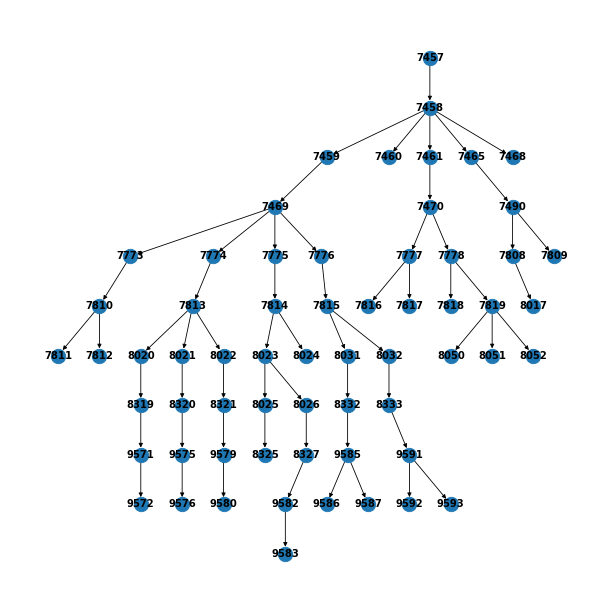

In [11]:
if VISUALIZE:
    pos = graphviz_layout(graph, prog="dot")
    fig = plt.figure(1, figsize=(10, 10), dpi=60)
    nx.draw(graph, pos, with_labels=True, font_weight='bold')

    # increase size of figure
    plt.show()


/tmp/ipykernel_299325/3686276393.py:28: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(backend_dom_tree, prog="dot")


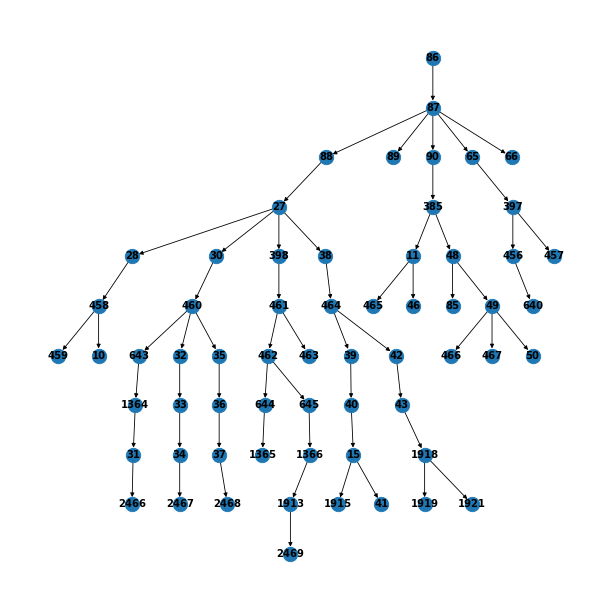

In [12]:
def build_dom_tree(graph):
    # now convert current graph to backend dom tree
    node_id_to_dom_id = {}
    for node_id in graph.nodes():
        dom_id = graph.nodes[node_id]["backendDOMNodeId"]
        node_id_to_dom_id[node_id] = dom_id
        

    # create new graph of backend dom tree
    backend_dom_tree = nx.DiGraph()
    for node_id in graph.nodes():
        backend_dom_tree.add_node(
            node_id_to_dom_id[node_id],
            role=graph.nodes[node_id]["role"],
        )

    for edge in graph.edges():
        backend_dom_tree.add_edge(
            node_id_to_dom_id[edge[0]],
            node_id_to_dom_id[edge[1]],
        )
        
    return backend_dom_tree
    
backend_dom_tree = build_dom_tree(graph)

if VISUALIZE:
    pos = graphviz_layout(backend_dom_tree, prog="dot")
    fig = plt.figure(1, figsize=(10, 10), dpi=60)
    nx.draw(backend_dom_tree, pos, with_labels=True, font_weight='bold')

    # increase size of figure
    plt.show()

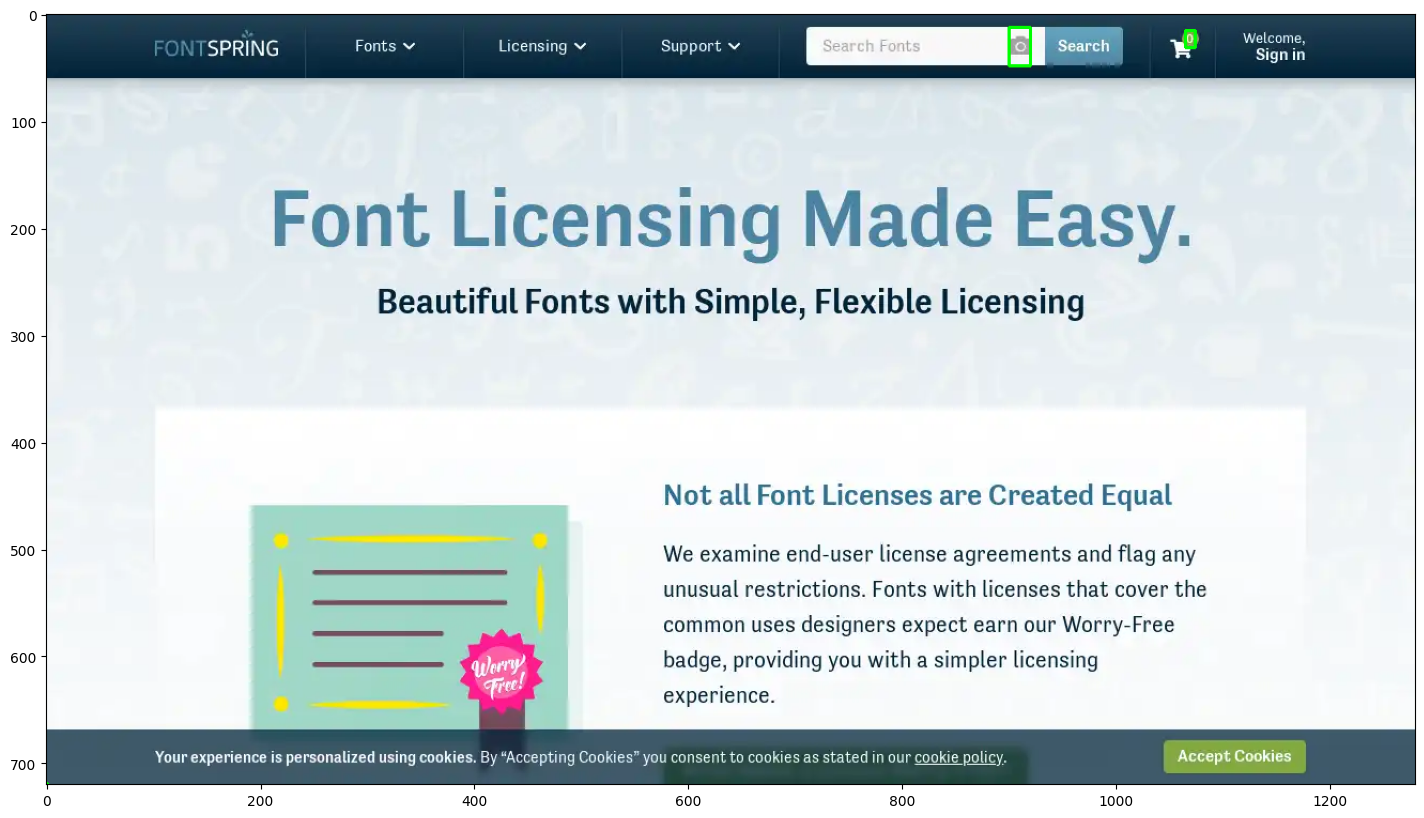

In [13]:
# let's store necceary information for each node: box, is absolute, z-index, etc.
# we can add more information later, but these are only information listed in the assessment

# node features: box, is absolute, z-index
# edges

def extract_dom_data(backend_dom_tree, box, style):
    nodes = []  # list of dictionary
    for dom_id in backend_dom_tree.nodes():
        try:
            xs = [int(d["x"]) for d in box[dom_id]["content"]]
            ys = [int(d["y"]) for d in box[dom_id]["content"]]
            x1, x2 = min(xs), max(xs)
            y1, y2 = min(ys), max(ys)
            
            is_absolute = style[dom_id]["position"] == "absolute"

            nodes.append({
                "id": dom_id,
                "box": [x1, y1, x2, y2],
                "is_absolute": is_absolute,
                "role": backend_dom_tree.nodes[dom_id]["role"],
            })
        except:
            continue
        
    edges = list(backend_dom_tree.edges())
    
    return nodes, edges


nodes, edges = extract_dom_data(backend_dom_tree, box, style)
        

if VISUALIZE:
    np_image = np.array(Image.open(image_path))
    
    for node in nodes:
        if node["is_absolute"]:
            x1, y1, x2, y2 = node["box"]
            cv2.rectangle(np_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    
    plt.figure(figsize=(20, 10))
    plt.imshow(np_image)

In [14]:
def pipeline(id):
    image_path = os.path.join(DATA_FOLDER, "{}/default_1280-720-screenshot.webp".format(id))
    
    if not os.path.exists(image_path):
        return
    
    try:
        # there are some errors in the data, so we need to handle them
        axtree, bb, box, style, viewport = read_data(id)
        kept_backend_dom_node_ids = get_kept_backend_dom_node_ids(viewport)
        graph = build_element_graph(axtree, kept_backend_dom_node_ids)
        backend_dom_tree = build_dom_tree(graph)
        nodes, edges = extract_dom_data(backend_dom_tree, box, style)
    
        with open(os.path.join(SAVE_FOLDER, f"{id}.json"), "w") as f:
            json.dump({"image_path": image_path, "nodes": nodes, "edges": edges}, f, indent=4)
    except:
        return


from multiprocessing import Pool

with Pool(32) as p:
    p.map(pipeline, ids)